# Problem 1

In [9]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme(style="darkgrid")

(a) For logistic regression based on MLE, plot $E_i^{(lr)}$ vs $s_i$

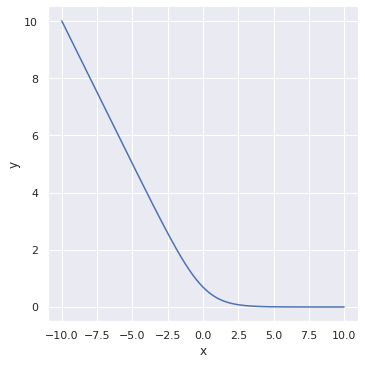

In [10]:
def logistic_regression_plot():
  x = np.arange(start=-10, stop=10, step=1e-2)
  y = np.log(1 + np.exp(-x))
  df = pd.DataFrame(dict(x = x, y = y))
  g = sns.relplot(x="x", y="y", kind="line", data=df)

logistic_regression_plot()

(b) For 2-class linear perceptron learning plot $E_i^{(p)}$ vs $s_i$

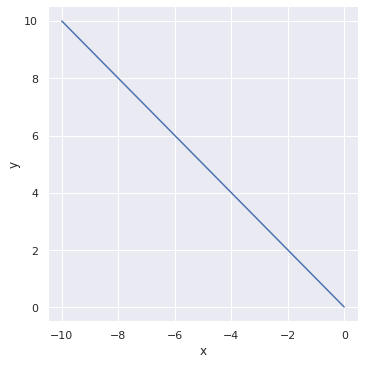

In [17]:
def linear_perceptron_plot():
  x = np.arange(start=-10, stop=0, step=1e-2)
  y = -1 * np.power(x,1)
  df = pd.DataFrame(dict(x = x, y = y))
  g = sns.relplot(x="x", y="y", kind="line", data=df)

linear_perceptron_plot()

(c). For the MSE objective function in a 2-class linear classification problem, plot $E_i^{(mse)}$ vs $s_i$

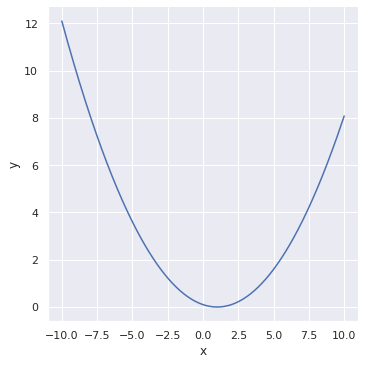

In [21]:
N = 10
def mse_linear_plot():
  x = np.arange(start=-10, stop=10, step=1e-2)
  y = np.power((x-1),2)/N
  df = pd.DataFrame(dict(x = x, y = y))
  g = sns.relplot(x="x", y="y", kind="line", data=df)

mse_linear_plot()

(d). Compare the plots of (a), (b), and (c) above. Describe how these 3 loss
functions contribute differently to the objective function. (For example,
compare the loss functions for correctly classified data points that are near the
decision boundary, and that are far from the decision boundary; likewise,
compare the loss functions for incorrectly classified data points that are near
the decision boundary, and that are far from the decision boundary.)

In [ ]:
# !unzip /content/drive/MyDrive/data.zip

# Problem 2
Given that the dimension of features is 9 (before augmentation), estimate the 𝒘 and try three regularization settings: [no regularization, 𝑙1 regularization, 𝑙2 regularization] and report the corresponding statistics. For each regularization setting to try, you need to search for a good regularization coefficient 𝜆 over the range −10 ≤ $\log_2 \lambda $ ≤ 10 with step size of 0.5 for $\log_2 \lambda $, and use MSE (mean squared error) on the validation set to choose the best one. During the parameter search, you need to do 5-fold cross validation on each parameter value you try.
Tip: after finding the best value of 𝜆, use that value for one final training run using all 𝑁𝑡𝑟 training data points (nothing held out as a validation set), to get the weight vector and training MSE
## (a) i.
Fill all your numerical results into the following table. (Each dataset should have a different table. So for this question you’ll have 3 tables.)

In [4]:
# Used Libraries
import pandas as pd
import numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
from numpy.linalg import norm
from prettytable import PrettyTable

from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV, RepeatedStratifiedKFold

In [5]:
def load_datasets(ques):

    dataset1 = np.load('/content/dataset1_dim9_Ntr10.npz')
    dataset2 = np.load('/content/dataset2_dim9_Ntr100.npz')
    dataset3 = np.load('/content/dataset3_dim9_Ntr1000.npz')
    dataset4 = np.load('/content/dataset4_dim2_Ntr10.npz')
    dataset5 = np.load('/content/dataset5_dim2_Ntr30.npz')
    dataset6 = np.load('/content/dataset6_dim2_Ntr100.npz')
    dataset7 = np.load('/content/dataset7_dim2_Ntr10.npz')
    dataset8 = np.load('/content/dataset8_dim2_Ntr30.npz')
    dataset9 = np.load('/content/dataset9_dim2_Ntr100.npz')

    if ques == 1:
      return {
          "dataset1": dataset1,
          "dataset2": dataset2,
          "dataset3": dataset3
      }

    else:
      return {
          "dataset4": dataset4,
          "dataset5": dataset5,
          "dataset6": dataset6,
          "dataset7": dataset7,
          "dataset8": dataset8,
          "dataset9": dataset9
       }


models = {
    "OLS": LinearRegression(),
    "lasso": Lasso(),
    "ridge": Ridge()
}

def get_coefs(estimator, intercept):
  coefs = []
  coefs.append(intercept)
  for coef in estimator.coef_:
    coefs.append(coef)
  return coefs

def sparsity(coefs):
  count = 0
  for coef in coefs:
    if (coef == 0.0) or (coef == -0.0):
      count+=1
  return count

def MSE(X,Y,w):
	return np.mean(np.square(np.dot(X,w)-Y))

def display(w,Xtest,Ytest,norm='l2',
	levels=None,
	w1_range=(-4.0, 6.1, 100),
	w2_range=(-4.0, 6.1, 100)):

	w = np.array(w)

	w1list = np.linspace(w1_range[0], w1_range[1], w1_range[2])
	w2list = np.linspace(w2_range[0], w2_range[1], w2_range[2])
	W1, W2 = np.meshgrid(w1list, w2list)

	Z = np.stack((w[0]*np.ones(W1.shape),W1,W2),axis=0)
	Z = Z.reshape((Z.shape[0],-1))
	Z = np.matmul(Xtest,Z) - Ytest.reshape((len(Ytest),1))
	Z = np.square(Z)
	Z = np.sum(Z, axis=0, keepdims=False)/Xtest.shape[0]
	Z = Z.reshape(W1.shape)
	
	if norm == 'l2':
		W_norm = np.square(W1) + np.square(W2)
	elif norm == 'l1':
		W_norm = np.abs(W1) + np.abs(W2)
	else:
		raise RuntimeError('Unimplemented norm. Please enter "l1" or "l2".')
		
	plt.figure()

	mse_ori = MSE(Xtest,Ytest,w)
	levels = [mse_ori, mse_ori+10]
	contour = plt.contour(W1, W2, Z, levels, colors='k')
	plt.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)

	if norm == 'l2':
		levels = [np.sum(np.square(w[1:]))]
	elif norm == 'l1':
		levels = [np.sum(abs(w[1:]))]
	else:
		raise RuntimeError('Unimplemented norm. Please enter "l1" or "l2".')
		
	contour = plt.contour(W1, W2, W_norm, levels, colors='r')
	plt.clabel(contour, colors = 'r', fmt = '%2.1f', fontsize=12)
	plt.plot(w[1],w[2],marker = ".",markersize=8)

	plt.title('Plot for 2D case')
	plt.xlabel('$w_1$')
	plt.ylabel('$w_2$')
	plt.axis('square')
	return

def print_stats(X, y, model, model_name, dataset, data, score, alpha):
    y_hat = model.predict(X)
    coefs = get_coefs(model, model.intercept_)
    if data == 'Train': 
      print(f"*********************************")
      print(f"Dataset       : {dataset}")
      print(f"Model         : {model_name}")
      print(f"\nMODEL SELECTION:")
      if score is not None:
        print(f"  Mean of MSE : {np.absolute(score)}")
        print(f"  Std of MSE  : {np.sqrt(np.absolute(score))}")
        print(f"  Best lambda : {alpha}")
      print(f"  L1 (W). : {norm(coefs, 1)}")
      print(f"  L2 (W). : {norm(coefs)}")
    else:
      print(f"\nMODEL PERFOMANCE:")
      print(f"  STD         : {mean_squared_error(y, y_hat, squared=False)}")
      print(f"  Sparsity    : {sparsity(coefs)}" )
    print(f"  MSE ({data}) : {mean_squared_error(y, y_hat)}")
    print("  W (Estimate): ")
    pprint(coefs)
    if data == 'Test': print(f"*********************************\n")


In [6]:
def grid_search(ques):

  for dataset, data in load_datasets(ques).items():

    for model_name, model in models.items(): 

      X = data['X_train']
      y = data['y_train']

      X_test = data['X_test']
      y_test = data['y_test']

      if model_name == "OLS":
        model.fit(X, y)
        score = None
        alpha = None
      else:
        params = {'alpha': np.linspace(-10, 10, 40)}
        gridCV = GridSearchCV(estimator=model, 
                          param_grid=params, 
                          scoring='neg_mean_squared_error',
                          n_jobs = -1,
                          refit=True)
        gridCV.fit(X, y)
        model = gridCV.best_estimator_
        score = gridCV.best_score_
        alpha = gridCV.best_params_["alpha"]

      print_stats(X, y, model, model_name, dataset, "Train", score, alpha)
      print_stats(X_test, y_test, model, model_name, dataset, "Test", score, alpha)

In [11]:
grid_search(1)

*********************************
Dataset       : dataset1
Model         : OLS

MODEL SELECTION:
  L1 (W). : 68.42523867301651
  L2 (W). : 27.80269624087995
  MSE (Train) : 4.192953483430722e-27
  W (Estimate): 
[-7.0147758204690405,
 3.202658605883155,
 -2.0105661844939,
 4.618914735756433,
 -8.486796391183383,
 5.345132338411684,
 -1.3685425279991423,
 -20.001426489792337,
 13.264101196294776,
 3.1123243827326554]

MODEL PERFOMANCE:
  STD         : 21.929382166285542
  Sparsity    : 0
  MSE (Test) : 480.8978021950023
  W (Estimate): 
[-7.0147758204690405,
 3.202658605883155,
 -2.0105661844939,
 4.618914735756433,
 -8.486796391183383,
 5.345132338411684,
 -1.3685425279991423,
 -20.001426489792337,
 13.264101196294776,
 3.1123243827326554]
*********************************

*********************************
Dataset       : dataset1
Model         : lasso

MODEL SELECTION:
  Mean of MSE : 119.48652326916924
  Std of MSE  : 10.930989125837113
  Best lambda : 3.333333333333332
  L1 (W). : 

ii. Based on statistics on all datasets, answer the following questions:
1. Comparison of test MSE with no regularizer, 𝑙1 regularizer, and 𝑙2 regularizer for a given 𝑁𝑡𝑟 (your answer might also depend on 𝑁𝑡𝑟)

  Analyzing the metrics, we can understand that test MSE $\propto$ 1/𝑁𝑡𝑟. So as the number of samples increases the test MSE decreases. For majority of the datasets, the test MSE loss has shown behaviour in this fashion: $L_1 < L_2 < OLS$

2. Does each regularizer lower the corresponding norm of 𝒘? by very much? Please explain. Why are these answers different depending on 𝑁𝑡𝑟?

  To understand how they operate differently, let’s have a look at how they change depending on the value of the weights.

  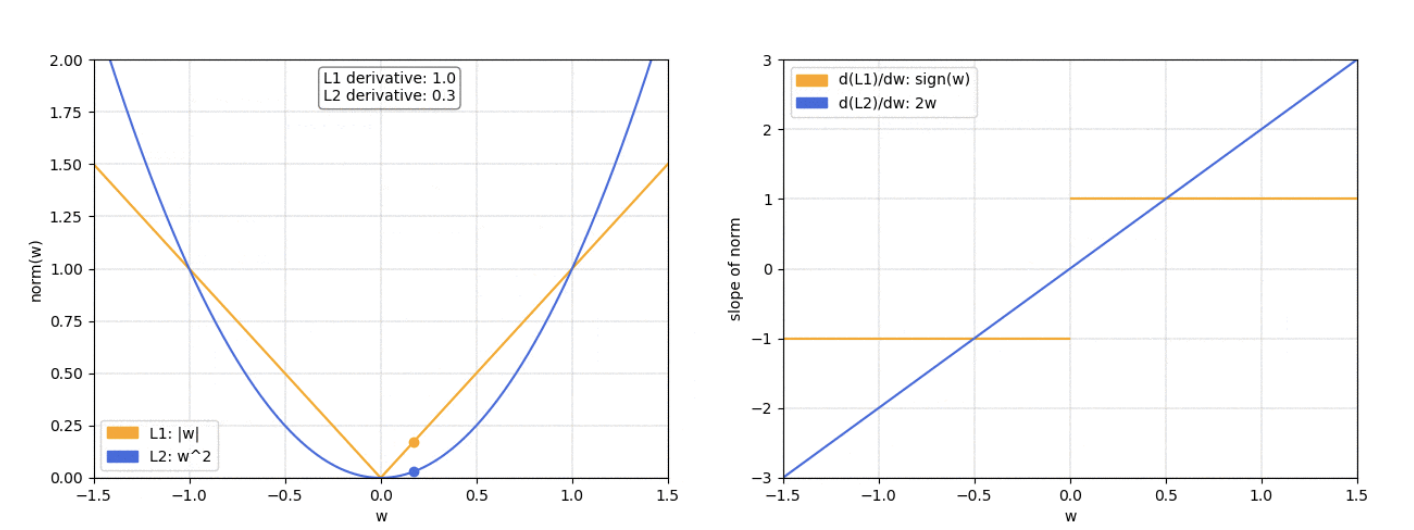

  On the left we have a plot of the L1 and L2 norm for a given weight w. On the right, we have the corresponding graph for the slope of the norms. As we can see, both L1 and L2 increase for increasing asbolute values of w. However, while the L1 norm increases at a constant rate, the L2 norm increases exponentially.
  This is important because, as we know, when doing gradiant descent we’ll update our weights based on the derivative of the loss function. So if we’ve included a norm in our loss function, the derivative of the norm will determine how the weights get updated.

  We can see that with the L2 norm as w gets smaller so does the slope of the norm, meaning that the updates will also become smaller and smaller. When the weights are close to 0 the updates will have become so small as to be almost negligible, so it’s unlikely that the weights will ever become 0.
On the other hand, with the L1 norm the slope is constant. This means that as w gets smaller the updates don’t change, so we keep getting the same “reward” for making the weights smaller. Therefore, the L1 norm is much more likely to reduce some weights to 0.'

  Through including the absolute value of weight parameters, L1 regularization can add the penalty term in cost function. On the other hand, L2 regularization appends the squared value of weights in the cost function



2. Please explain. Why are these answers different depending on 𝑁𝑡𝑟?

  The weights are $\propto$ 𝑁𝑡𝑟. As the number of samples increase, the weights also change and increase which therby increases the corrsponding norm that is being calculated. 

3. Observe and explain the dependence of sparsity on regression method, and on different values of 𝑁𝑡𝑟 and 𝜆.

  We can say that, Sparsity $\propto$ λ and Sparsity $\propto$ 1/𝑁𝑡𝑟. Also from the results, we can observe that the sparsity is mostly dependent on $\lambda$ or penalizing term. No matter what 𝑁𝑡𝑟 we use, we can see it depends mostly on what regularization we use than 𝑁𝑡𝑟. So sparsity would be independent of 𝑁𝑡𝑟 or we can say it might increase or decrease depending on the data itself. 

  For Ridge, by changing the values of λ, we are basically controlling the penalty term. Higher the values of λ, bigger is the penalty and therefore the magnitude of coefficients are reduced.

  Fo Lasso, we can see that as we increased the value of λ, coefficients were approaching towards zero, but if you see in case of lasso, even at smaller λ, our coefficients are reducing to absolute zeroes. Therefore, lasso selects the only some feature while reduces the coefficients of others to zero. 

In [12]:
# Execute for datasets [4-9]
grid_search(2)

*********************************
Dataset       : dataset4
Model         : OLS

MODEL SELECTION:
  L1 (W). : 16.50352453166529
  L2 (W). : 10.221157922129624
  MSE (Train) : 95.38019904643613
  W (Estimate): 
[6.772657107593259, -2.4928513046530174, 7.238016119419012]

MODEL PERFOMANCE:
  STD         : 12.786227444949263
  Sparsity    : 0
  MSE (Test) : 163.48761227397378
  W (Estimate): 
[6.772657107593259, -2.4928513046530174, 7.238016119419012]
*********************************

*********************************
Dataset       : dataset4
Model         : lasso

MODEL SELECTION:
  Mean of MSE : 162.60701187453904
  Std of MSE  : 12.751745444233862
  Best lambda : 1.7948717948717938
  L1 (W). : 9.559665309165462
  L2 (W). : 6.8213139961214715
  MSE (Train) : 98.16669835923324
  W (Estimate): 
[5.4266418312538285, 0.0, 4.1330234779116335]

MODEL PERFOMANCE:
  STD         : 11.761285060237483
  Sparsity    : 1
  MSE (Test) : 138.3278262681654
  W (Estimate): 
[5.4266418312538285, 0.0, 4.1

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19881.832758845543, tolerance: 1.9556804079189722
  positive)


*********************************
Dataset       : dataset6
Model         : lasso

MODEL SELECTION:
  Mean of MSE : 110.82336829035425
  Std of MSE  : 10.527267845474164
  Best lambda : -0.76923076923077
  L1 (W). : 3.837248480351192
  L2 (W). : 2.6379022937851886
  MSE (Train) : 101.4468352921414
  W (Estimate): 
[1.1882755330645067, 2.33394200296325, 0.3150309443234351]

MODEL PERFOMANCE:
  STD         : 10.067535177597657
  Sparsity    : 0
  MSE (Test) : 101.35526455216629
  W (Estimate): 
[1.1882755330645067, 2.33394200296325, 0.3150309443234351]
*********************************

*********************************
Dataset       : dataset6
Model         : ridge

MODEL SELECTION:
  Mean of MSE : 110.77606326587117
  Std of MSE  : 10.525020820210816
  Best lambda : 10.0
  L1 (W). : 3.7342496791186064
  L2 (W). : 2.600462734242446
  MSE (Train) : 101.36141700139379
  W (Estimate): 
[1.2122402590285426, 2.2887727356866647, 0.23323668440339906]

MODEL PERFOMANCE:
  STD         : 10.070116


      FOR DATASET: dataset4


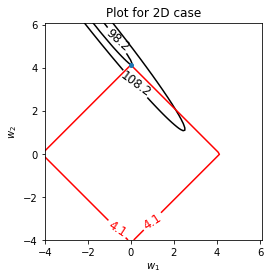

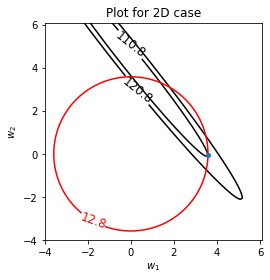


      FOR DATASET: dataset5


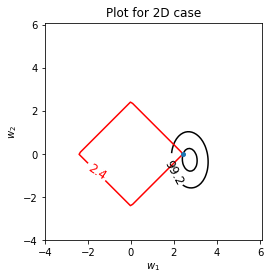

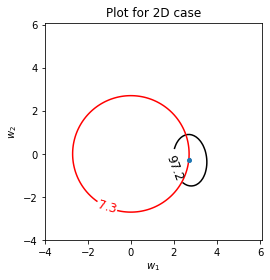

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 19881.832758845543, tolerance: 1.9556804079189722
  positive)



      FOR DATASET: dataset6


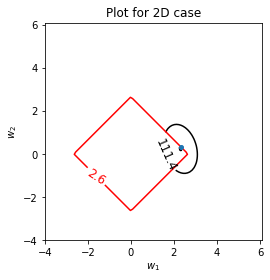

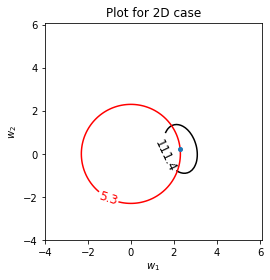


      FOR DATASET: dataset7


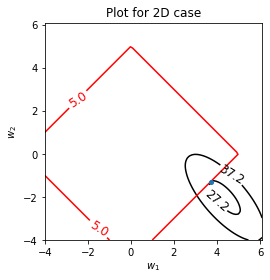

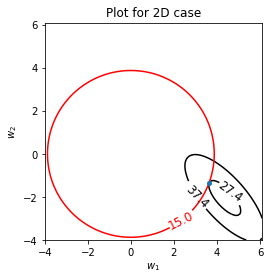


      FOR DATASET: dataset8


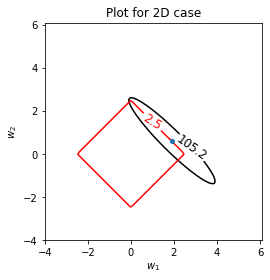

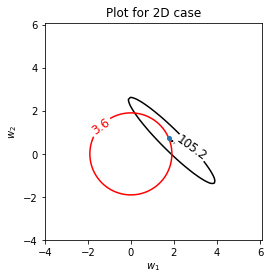


      FOR DATASET: dataset9


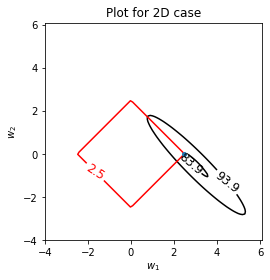

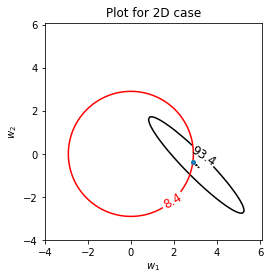

In [6]:
def display_plots(ques):

    for (dataset, data) in load_datasets(ques).items():

        for (model_name, model) in models.items():

            X = data['X_train']
            y = data['y_train']

            X_test = data['X_test']
            y_test = data['y_test']

            if model_name == 'OLS':
                continue
            else:
                params = {'alpha': np.linspace(-10, 10, 40)}
                gridCV = GridSearchCV(estimator=model,
                                      param_grid=params,
                                      scoring='neg_mean_squared_error', n_jobs=-1,
                                      refit=True)
                gridCV.fit(X, y)
                estimator = gridCV.best_estimator_
                coefs = get_coefs(estimator, estimator.intercept_)

                X_train = np.concatenate((np.ones((len(X), 1)),
                                          X), axis=1)
                
                if model_name == 'lasso':
                  print(f'\n=================================')
                  print(f'      FOR DATASET: {dataset}')
                  print(f'=================================')
                  display(coefs, X_train, y, norm='l1')
                if model_name == 'ridge':
                  display(coefs, X_train, y, norm='l2')
        plt.show()


display_plots(2)

2. (b).iii 
  1. Observe and explain how the plots relate to sparsity.

  The square and disk regions are feasible regions for lasso (L1) regression and ridge (L2) regression respectively. Heuristically, for each method, we are looking for the intersection of the ellipses and the red highlighted region as the objective is to minimize the error function while maintaining feasibility.
  That being said, it is clear to see that the L1 constraint, which corresponds to the square feasible region, is more likely to produce an intersection that has one component of the solution is zero (i.e., the sparse model) due to the geometric properties of ellipses, disks, and squares. It is simply because squares have corners (of which one component is zero) that are easier to intersect with the ellipses that extending diagonally.

2. Can you explain how much effect the regularizer has, from looking at the plots (i.e., how different the regularized performance (MSE) is from the unregularized performance)

*   The lasso penalty will force some of the coefficients quickly to zero. This means that features are removed from the model, hence the sparsity. You can see that in the graph for lasso that the function is likely to hit the possible value space on one of the corners, on the axes. This implies that β1 is 0. 
*   Ridge regression will more or less compress the coefficients to become smaller. This does not necessarily result in 0 coefficients and removal of features. For graph for ridge, where the space of allowed values is round due to the quadratic constraint, the function can hit the possible space in more arbitrary places

3. Observe and explain how Lasso has a different effect with the “special case” datasets than the other datasets

The lasso solution exihibits shrinkage, in that large enough least squares coefficients are shrunken towards zero by λ; the ridge regression solution is never sparse and compared to the lasso, preferentially shrinkage the larger least squares coefficients even more


